## cell2fate benchmark on cell cycle data

Notebook benchmarks velocity, latent time inference, and cross boundary correctness using cell2fate on cell cycle data.

cell2fate requires `anndata = 0.8.0` and `scvi-tools = 0.16.1`

## Library imports

In [1]:
from pathlib import PosixPath

import pandas as pd
import scipy

import anndata as ad
import cell2fate as c2f
import scvelo as scv
from cellrank.kernels import VelocityKernel

Global seed set to 0


## Function defination

In [2]:
def get_time_correlation(ground_truth, estimated) -> float:
    """Compute Spearman correlation between ground truth and estimated values.

    Parameters
    ----------
    ground_truth
        Array of ground truth value.
    estimated
        Array of estimated values.

    Returns
    -------
    Spearman correlation.
    """
    return scipy.stats.spearmanr(ground_truth, estimated)[0]

## Constants

In [3]:
DATASET = "cell_cycle"

In [4]:
STATE_TRANSITIONS = [("G1", "S"), ("S", "G2M")]

In [5]:
## Please manually set your dataset location
DATA_DIR = PosixPath("/ictstr01/home/icb/weixu.wang/regulatory_velo/data")

In [6]:
SAVE_DATA = True
if SAVE_DATA:
    (DATA_DIR / DATASET / "results").mkdir(parents=True, exist_ok=True)

## Data loading

using original count data to train cell2fate model

In [7]:
adata_raw = ad.read_h5ad(DATA_DIR / DATASET / "processed" / "adata.h5ad")
genes = ad.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad").var_names
umap = ad.read_h5ad(DATA_DIR / DATASET / "processed" / "adata_processed.h5ad").obsm["X_umap"].copy()
adata = adata_raw[:, genes].copy()

In [8]:
adata.obsm["X_umap"] = umap

In [9]:
adata

AnnData object with n_obs × n_vars = 1146 × 395
    obs: 'phase', 'fucci_time'
    var: 'ensum_id'
    obsm: 'X_umap'
    layers: 'spliced', 'total', 'unspliced'

## Velocity pipeline

In [10]:
clusters_to_remove = []
adata.obs["clusters"] = "0"

adata = c2f.utils.get_training_data(
    adata,
    cells_per_cluster=10**5,
    cluster_column="clusters",
    remove_clusters=clusters_to_remove,
    min_shared_counts=0,
    n_var_genes=2000,
)

Keeping at most 100000 cells per cluster


/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/scvelo/core/_anndata.py:622: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs[f"initial_size_{layer}"] = get_size(adata, layer)


Skip filtering by dispersion since number of variables are less than `n_top_genes`.


In [11]:
c2f.Cell2fate_DynamicalModel.setup_anndata(adata, spliced_label="spliced", unspliced_label="unspliced")

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [12]:
n_modules = c2f.utils.get_max_modules(adata)

Leiden clustering ...
         Falling back to preprocessing with `sc.pp.pca` and default params.


/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/scanpy/preprocessing/_simple.py:843: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


Number of Leiden Clusters: 13
Maximal Number of Modules: 14


In [13]:
mod = c2f.Cell2fate_DynamicalModel(adata, n_modules=n_modules)

In [14]:
mod.train()

/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/pytorch_lightning/core/lightning.py:2054: DeprecationWarning: `torch.distributed._sharded_tensor` will be deprecated, use `torch.distributed._shard.sharded_tensor` instead
  from torch.distributed._sharded_tensor import pre_load_state_dict_hook, state_dict_hook
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/pytorch_lightning/trainer/configuration_validator.py:120: UserWarning: You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.
  rank_zero_warn("You passed in a `val_dataloader` but have no `validation_step`. Skipping val loop.")
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
Set SLURM handle signals.
/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:432: UserWarning: The 

Epoch 500/500: 100%|██████████| 500/500 [04:40<00:00,  1.78it/s, v_num=1, elbo_train=1.78e+6]


In [15]:
adata = mod.export_posterior(
    adata, sample_kwargs={"batch_size": None, "num_samples": 30, "return_samples": True, "use_gpu": False}
)

Sampling global variables, sample: 100%|██████████| 29/29 [00:04<00:00,  5.93it/s]


Computing total RNAvelocity ...


/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/cell2fate/_cell2fate_DynamicalModel.py:334: DeprecationWarning: `neighbors` is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute neighbors with Scanpy.
  scv.pp.neighbors(adata, n_neighbors = n_neighbours)
/home/icb/weixu.wang/miniconda3/envs/cell2fate_env2/lib/python3.9/site-packages/scvelo/preprocessing/neighbors.py:233: DeprecationWarning: Automatic computation of PCA is deprecated since scvelo==0.4.0 and will be removed in a future version of scVelo. Please compute PCA with Scanpy first.
  _set_pca(adata=adata, n_pcs=n_pcs, use_highly_variable=use_highly_variable)


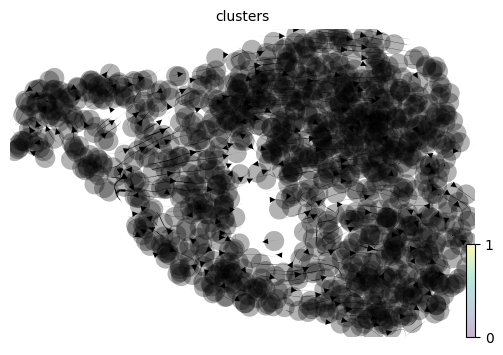

In [16]:
mod.compute_and_plot_total_velocity(adata, delete=False)

In [17]:
adata.layers["velocity"] = adata.layers["Velocity"].numpy()
adata.layers["Ms"] = adata.layers["spliced"].copy()

In [18]:
time_correlation = [get_time_correlation(ground_truth=adata.obs["fucci_time"], estimated=adata.obs["Time (hours)"])]

In [19]:
scv.tl.velocity_graph(adata, vkey="velocity", n_jobs=1)
scv.tl.velocity_confidence(adata, vkey="velocity")

computing velocity graph (using 1/112 cores)


  0%|          | 0/1146 [00:00<?, ?cells/s]

    finished (0:00:03) --> added 
    'velocity_graph', sparse matrix with cosine correlations (adata.uns)
--> added 'velocity_length' (adata.obs)
--> added 'velocity_confidence' (adata.obs)
--> added 'velocity_confidence_transition' (adata.obs)


## Cross boundary-correctness

In [20]:
vk = VelocityKernel(adata, vkey="velocity", xkey="spliced").compute_transition_matrix()

cluster_key = "phase"
rep = "X_pca"

score_df = []
for source, target in STATE_TRANSITIONS:
    cbc = vk.cbc(source=source, target=target, cluster_key=cluster_key, rep=rep)

    score_df.append(
        pd.DataFrame(
            {
                "State transition": [f"{source} - {target}"] * len(cbc),
                "CBC": cbc,
            }
        )
    )
score_df = pd.concat(score_df)

  0%|          | 0/1146 [00:00<?, ?cell/s]

  0%|          | 0/1146 [00:00<?, ?cell/s]

## Data saving

In [22]:
if SAVE_DATA:
    pd.DataFrame({"time": time_correlation}, index=adata.obs_names).to_parquet(
        path=DATA_DIR / DATASET / "results" / "cell2fate_correlation.parquet"
    )
    adata.obs[["velocity_confidence"]].to_parquet(path=DATA_DIR / DATASET / "results" / "cell2fate_confidence.parquet")
    score_df.to_parquet(path=DATA_DIR / DATASET / "results" / "cell2fate_cbc.parquet")